# **Predicting 2022 French presidential elections**


**Authors:** *Morvan Theo, Islamov Rustem, Popov Nicolai, Wasik Thomas, Bouley Alexis*


This challenge was done as a project for the Master 2 Data Science (2021/2022), DATACAMP course:
<br><br>


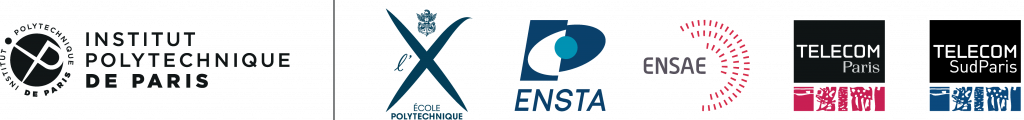

## Introduction

The French presidential elections are elections to elect the next president of the French republic. They take place every 5 years. 
It is quite common for candidates to run several times in a row. <br>
We are interested in a model to predict the percentage of votes that candidates will receive in relation to the number of registered voters. 
In this challenge we are interested in the three main candidates of the years 2017 and 2022: Melenchon, Macron and Le pen. <br>
We are also interested in the percentage of abstention, blank vote, and null vote as well as the total percentage of others candidates. <br>
From the scores achieved by each of these candidates in 2017 and social data, the objective is to predict the score of each of these candidates by city in 2022. <br>
<br>
In particular, in order to obtain a generalization for the following elections, it is preferable to use easily interpretable methods. For example, linear regressions where one can directly access the coefficients used by the model for each of the features.<br>



## Description of the Data

The data is composed of the percentages of votes received by each of the three major candidates in 2017. The dataset is also composed of the percentage of votes received by all the other candidates as well as the percentage of abstention, blank vote and null vote in 2017. <br>
<br>
A list of the features used is available here: https://www.insee.fr/fr/statistiques/6454652?sommaire=6454687#dictionnaire
<br>
<br>
These features are mainly composed of data related to the employment status of individuals as well as their ages and income.


### Output Data


The output data should be a ndarray of shape (batch_size, 7) with the following columns to predict:

- % Absence / registered
- % Null Vote / registered
- % Blank Vote / registered
- % Others Candidates Vote / registered
- % MACRON Vote / registered
- % MELENCHON Vote / registered
- % LE PEN Vote / registered

## Evaluation Metric

We aim to predict the percentage of vote by category. This is a regression problem, we therefore use the root mean square error here:


$$RMSE =\sqrt{\frac{1}{n \times p} \sum_{i=1}^n \sum_{j=1}^p (y_{i, j} - \hat{y}_{i, j})^2}.$$

Another metric that we use to evaluate the predictions is 

$$MAE =\frac{1}{n \times p} \sum_{i=1}^n \sum_{j=1}^p  |y_{i, j} - \hat{y}_{i, j}|.$$

The final evaluation is done according to the mixed score which is an average of RMSE and MAE.

## Download Data

You can download the data with the command:

In [406]:
! python download_data.py

The data is downloading from the various sources and then aggregated to match our objectives. The downloaded datasets are initially rather big, so make sure that you have a robust internet connection or it might take some time. <br>We kindly refer a user to find more detailed information in the README file about the data in the case of any difficulties with the downloading

## Reading the data

First, we need to import modules and implemented functions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from problem import _target_column_name, _ignore_column_names
from problem import get_train_data, get_test_data
from problem import get_raw_train_data

Now we want to show explicitely the preprocessing step as it is the key to success with the project. The description below explains and shows how we join original data with external ones. To show this, we use `get_raw_train_data` function which returnes only the original dataset (raw data is available for train data only).

In [4]:
X_train, y_train = get_raw_train_data()

## Data Analysis

We will first perform some analysis regarding the baseline features in our dataset. <br>

In [409]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27849 entries, 0 to 27848
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CODGEO                     27849 non-null  object 
 1   % Abs/Ins_2017             27849 non-null  float64
 2   % Vot/Ins_2017             27849 non-null  float64
 3   % Nuls/Ins_2017            27849 non-null  float64
 4   % Blancs/Ins_2017          27849 non-null  float64
 5   %_Exp/Ins_2017             27849 non-null  float64
 6   % Autres/Ins_2017          27849 non-null  float64
 7   % Voix/Ins_MACRON_2017     27849 non-null  float64
 8   % Voix/Ins_MELENCHON_2017  27849 non-null  float64
 9   % Voix/Ins_LEPEN_2017      27849 non-null  float64
dtypes: float64(9), object(1)
memory usage: 2.1+ MB


One can notice that there is no missing values in our data, which is a great thing. However, we do not have the location. We are going to load the required data and start make some visualizations

In [410]:
from problem import get_location_data
data_location = get_location_data()

In [411]:
X_train= X_train.merge(data_location, on='CODGEO', how='left')

In [412]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27849 entries, 0 to 27848
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CODGEO                     27849 non-null  object 
 1   % Abs/Ins_2017             27849 non-null  float64
 2   % Vot/Ins_2017             27849 non-null  float64
 3   % Nuls/Ins_2017            27849 non-null  float64
 4   % Blancs/Ins_2017          27849 non-null  float64
 5   %_Exp/Ins_2017             27849 non-null  float64
 6   % Autres/Ins_2017          27849 non-null  float64
 7   % Voix/Ins_MACRON_2017     27849 non-null  float64
 8   % Voix/Ins_MELENCHON_2017  27849 non-null  float64
 9   % Voix/Ins_LEPEN_2017      27849 non-null  float64
 10  latitude                   27843 non-null  float64
 11  longitude                  27843 non-null  float64
 12  Superficie                 27843 non-null  float64
dtypes: float64(12), object(1)
memory usage: 3.0+ M

We have some missing values. Let's check them to see how big this cities are

In [413]:
# X_train[X_train['latitude'].isnull()]['CODGEO'].apply(lambda element : element[:2]).unique()
X_train[X_train['latitude'].isnull()]['CODGEO']

5014     76095
5051     69123
7408     55138
19848    13055
22728    76601
26213    75056
Name: CODGEO, dtype: object

One can we see a 75, related to Paris. Indeed, in our data, we have values for the total city, whereas in the external dataset it is at an "arrondissement" level. We are going to fix this

In [414]:
paris_boroughs = [] 
for i in range(1,21):
    if i<10:
        paris_boroughs.append(f"7510{i}")
    else:
        paris_boroughs.append(f"751{i}")
paris_data = data_location[data_location['CODGEO'].isin(paris_boroughs)]
X_train.loc[X_train['CODGEO'].str.contains('75056'),['latitude', 'longitude', 'Superficie'] ] = paris_data.agg({'latitude':np.mean,'longitude':np.mean, "Superficie":np.sum}).values

The modification performed here can been found in a proper manner both in the problem file but also in the estimator

We have fixed it for Paris, but this issue might appears for other french cities. Competitors are welcomed to look online and check for other potential similar issues in cities such as Lyon and Marseille (potentially in dataset?)

Regarding the other cities, we will just take the mean per department (two first values of CODGEO)

In [415]:
def missing_values_department(X, data_location):
    X = X.copy()
    X["Departement"] = X["CODGEO"].apply(lambda element: element[:2])
    data_location["Departement"] = data_location["CODGEO"].apply(lambda element: element[:2])
    data_group = data_location.groupby("Departement")[["latitude", "longitude", "Superficie"]].mean()
    for column in data_group.columns:
        globals()[f"dict_{column}"] = data_group[column].to_dict()
        X.loc[X[column].isnull(), "Departement"].map(
            globals()[f"dict_{column}"]
        ).value_counts()
        X[column].fillna((X[column].mean()), inplace=True)
    X = X.drop(columns=["Departement"])
    return X

In [416]:
X_train = missing_values_department(X_train,data_location)

In [417]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27849 entries, 0 to 27848
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CODGEO                     27849 non-null  object 
 1   % Abs/Ins_2017             27849 non-null  float64
 2   % Vot/Ins_2017             27849 non-null  float64
 3   % Nuls/Ins_2017            27849 non-null  float64
 4   % Blancs/Ins_2017          27849 non-null  float64
 5   %_Exp/Ins_2017             27849 non-null  float64
 6   % Autres/Ins_2017          27849 non-null  float64
 7   % Voix/Ins_MACRON_2017     27849 non-null  float64
 8   % Voix/Ins_MELENCHON_2017  27849 non-null  float64
 9   % Voix/Ins_LEPEN_2017      27849 non-null  float64
 10  latitude                   27849 non-null  float64
 11  longitude                  27849 non-null  float64
 12  Superficie                 27849 non-null  float64
dtypes: float64(12), object(1)
memory usage: 3.0+ M

Now let's perform some visualization

<Axes: xlabel='value', ylabel='Count'>

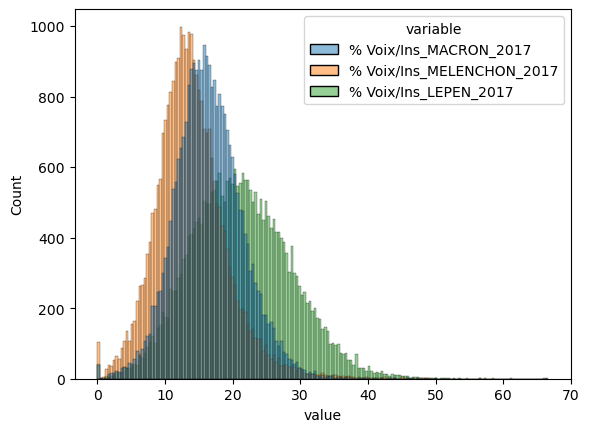

In [418]:
variables = ["% Voix/Ins_MACRON_2017", "% Voix/Ins_MELENCHON_2017","% Voix/Ins_LEPEN_2017"]
df_plot = X_train[["CODGEO","% Voix/Ins_MACRON_2017", "% Voix/Ins_MELENCHON_2017","% Voix/Ins_LEPEN_2017"]].melt(id_vars='CODGEO')
sns.histplot(data=df_plot, x="value",hue="variable")

It seems that Mme Le Pen got very high score in some communes, whereas M. Melenchon and M. Macron might have got more balanced scores. Mme Le Pen most likely overperformed in small cities, whereas the two big candidates got higher scores in bigger cities

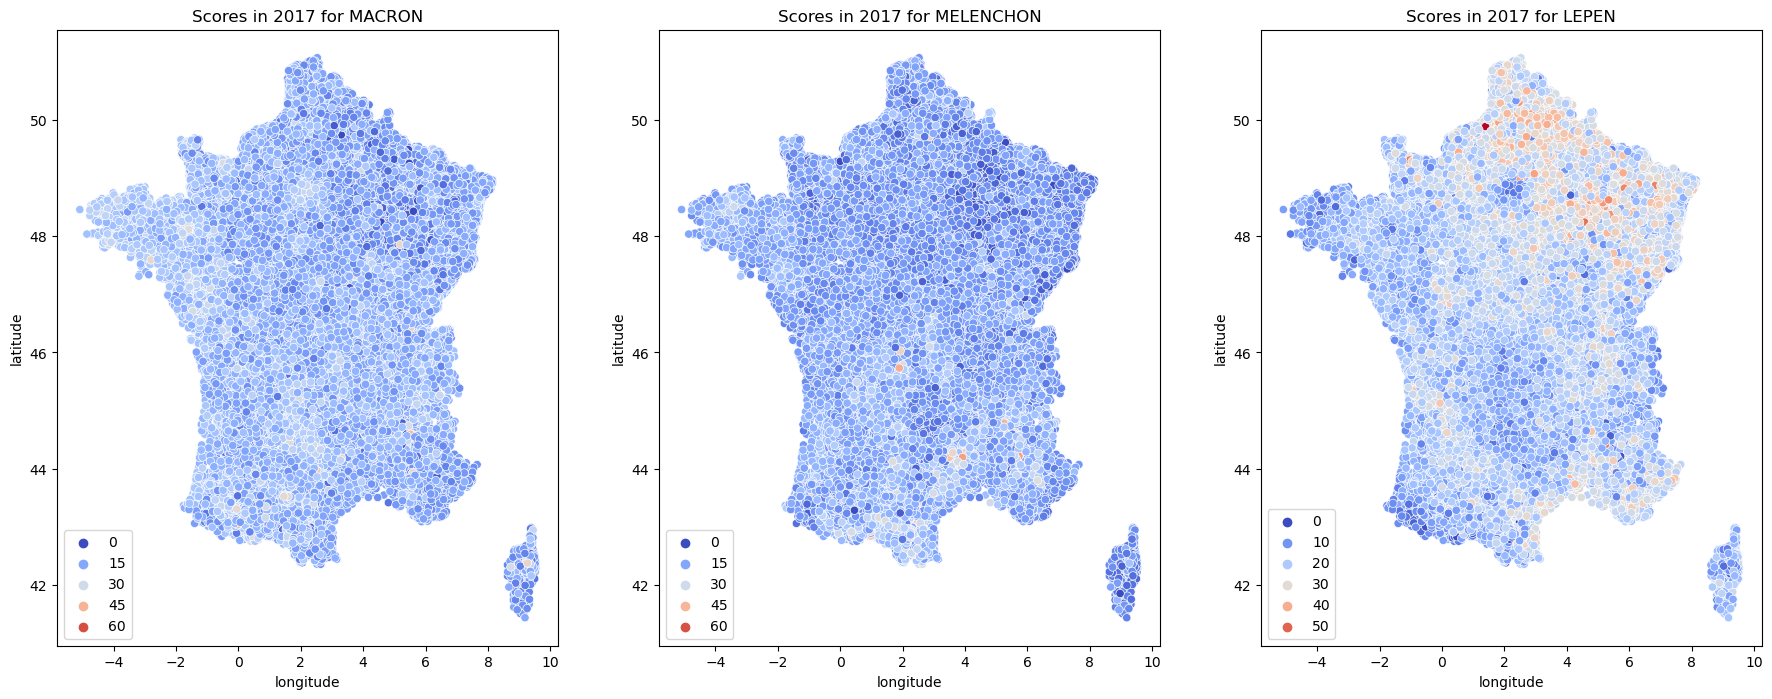

In [419]:
fig, axes = plt.subplots(1,3, figsize=(22, 8))
main_candidates = ['MACRON', "MELENCHON","LEPEN"]
for i, candidate in enumerate(main_candidates):
    sns.scatterplot(
        data=X_train, 
        x="longitude",
        y="latitude",
        hue=f'% Voix/Ins_{candidate}_2017',
        palette='coolwarm',
        ax=axes[i],
    )
    axes[i].set_title(f'Scores in 2017 for {candidate}')
    axes[i].legend(loc=3)

The plots for M. Macron & M. Melenchon might not be as illustrative as the one for M. Le Pen, due to some very high values. Let's filter them to have clearer graphs.

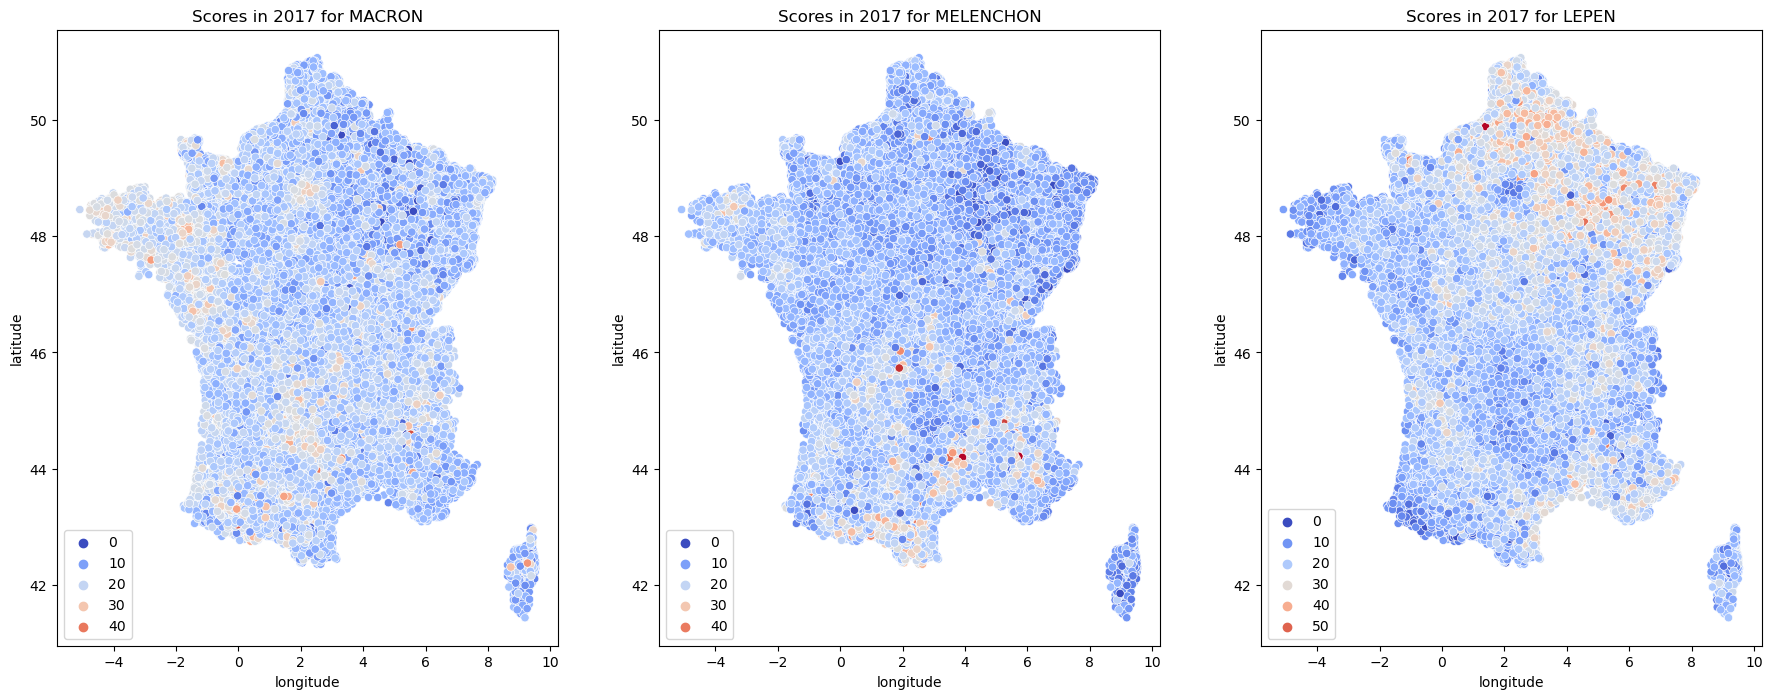

In [420]:
fig, axes = plt.subplots(1,3, figsize=(22, 8))
main_candidates = ['MACRON', "MELENCHON","LEPEN"]
for i, candidate in enumerate(main_candidates):
    X_plot = X_train.copy()
    if candidate !="LEPEN":
        X_plot = X_plot[X_plot[f'% Voix/Ins_{candidate}_2017']<50]
    sns.scatterplot(
        data=X_plot, 
        x="longitude",
        y="latitude",
        hue=f'% Voix/Ins_{candidate}_2017',
        palette='coolwarm',
        ax=axes[i],
    )
    axes[i].set_title(f'Scores in 2017 for {candidate}')
    axes[i].legend(loc=3)

Let's compare the scores between the two elections (2017 and 2022)

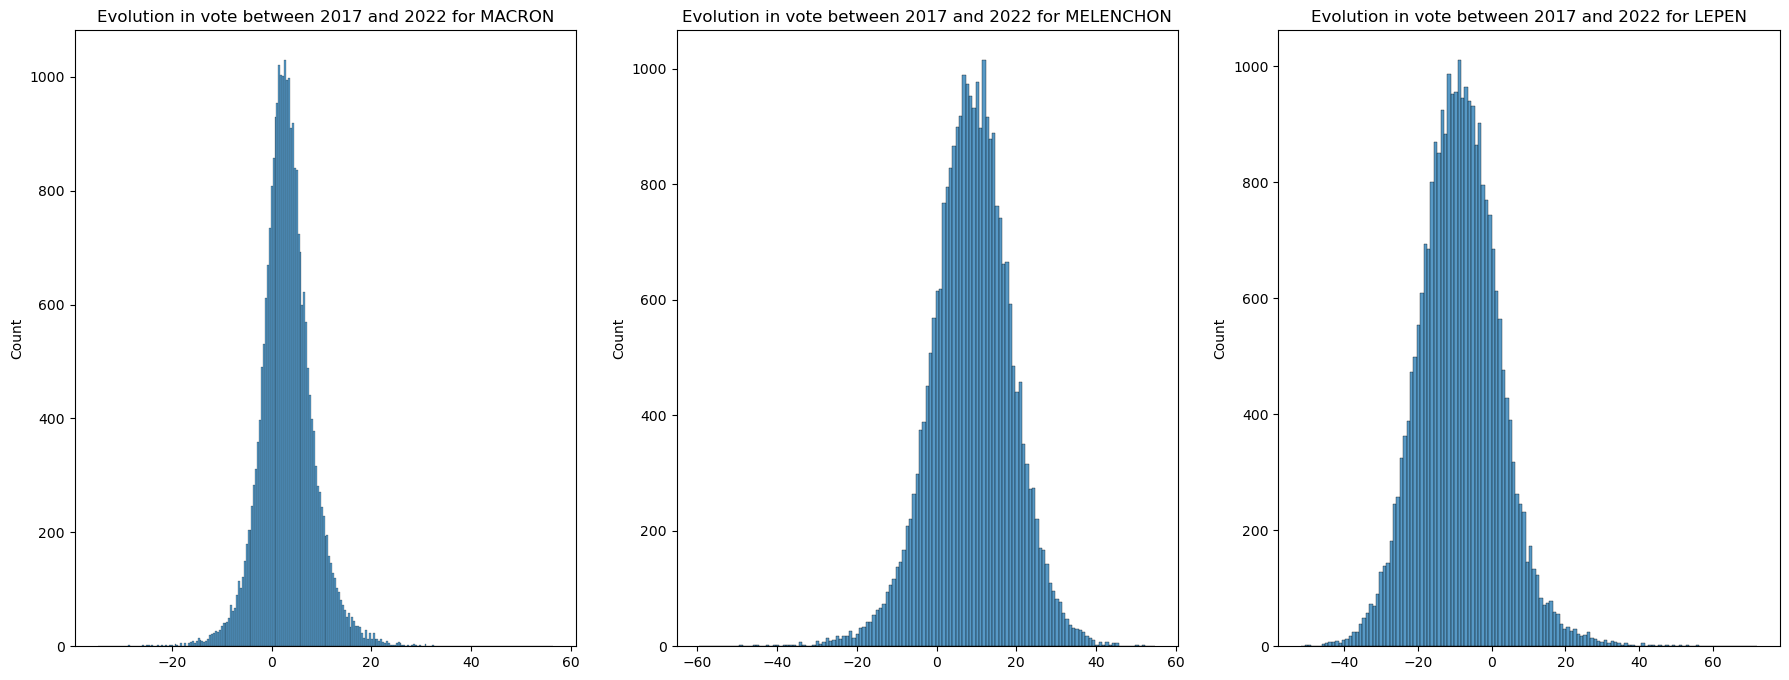

In [421]:
fig, axes = plt.subplots(1,3, figsize=(22, 8))
main_candidates = ['MACRON', "MELENCHON","LEPEN"]
for i, candidate in enumerate(main_candidates):
    plot_2017 = y_train[f'% Voix/Ins_{candidate}_2022'].copy()
    plot_2022 = X_train[f'% Voix/Ins_{candidate}_2017']
    sns.histplot(plot_2017 - plot_2022,ax=axes[i])
    axes[i].set_title(f'Evolution in vote between 2017 and 2022 for {candidate}')

These plots are very interesting for several reasons : 
1. Both M. Macron & Melenchon proportionally increased their relative scores in different cities
2. Even though Mme. Le Pen got a higher national score, it seems that in many cities she in the end got a lower score. Most likely, she increased her score in big cities, counterbalancing this effect in smaller cities

In [422]:
X_train['LEPEN_evolutions'] = y_train[f'% Voix/Ins_{candidate}_2022'] - X_train[f'% Voix/Ins_{candidate}_2017']

<Axes: xlabel='longitude', ylabel='latitude'>

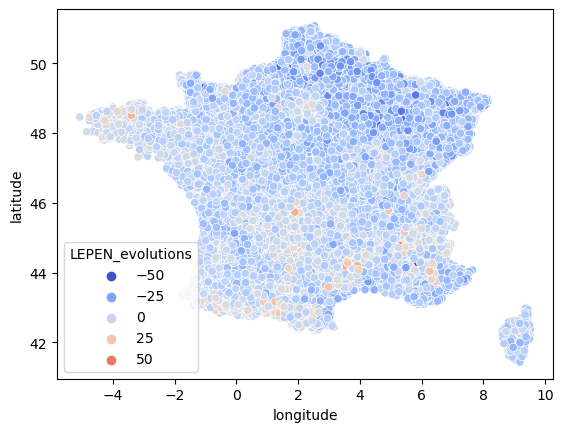

In [423]:
sns.scatterplot(data=X_train, x="longitude",y="latitude",hue='LEPEN_evolutions',palette='coolwarm')

Mme. LePen mainly increased her scores in Brittany, Ile-de-France and in the south of France. The first two regions are densely populated, which explains in the end the higher score

In [424]:
X_train.drop(columns={'LEPEN_evolutions'},inplace=True) #the variable was present only for data visualization

Let's have a quick look at the Absentation, other candidates and null votes evolutions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


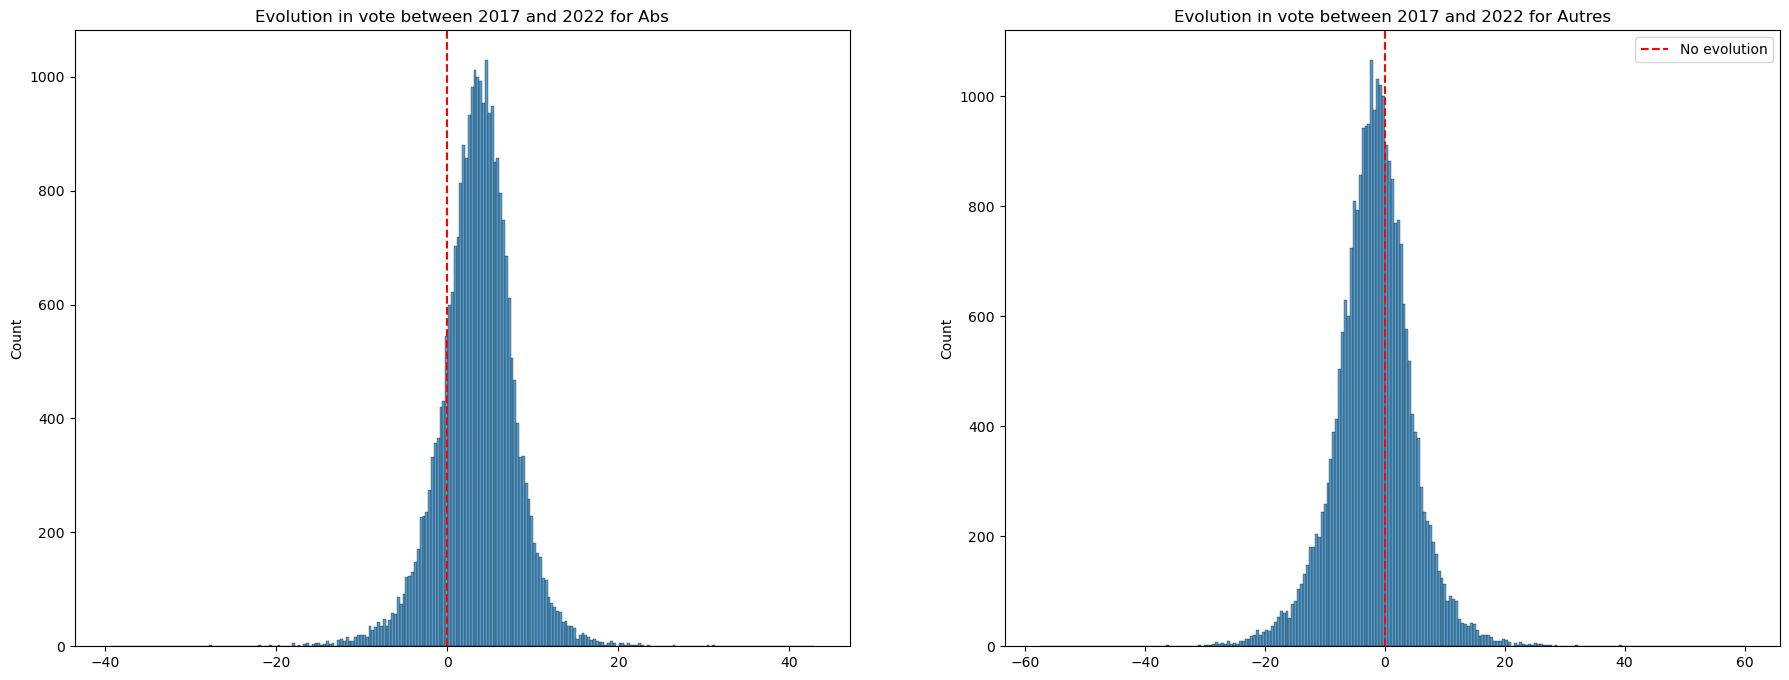

In [425]:
other_candidates = ['Abs',"Autres"]
fig, axes = plt.subplots(1,len(other_candidates), figsize=(22, 8))

for i, candidate in enumerate(other_candidates):
    sns.histplot(y_train[f'% {candidate}/Ins_2022'] - X_train[f'% {candidate}/Ins_2017'],ax=axes[i])
    axes[i].set_title(f'Evolution in vote between 2017 and 2022 for {candidate}')
    axes[i].axvline(0,color='red', linestyle='--', label="No evolution")
    plt.legend()

One can notice two elements : 
1. An increasing abstention
2. A polarization of the votes around the main candidates with the reinforcement of the logic of the useful vote

We can also look at the external data that we have downloaded. It is composed of two different INSEE databases, one on the job market for each "commune", and the second one regarding the revenues in the different job mark

In [426]:
from problem import get_external_data
import os

df_external_features = get_external_data()

In [427]:
df_external_features.head()

,CODGEO,NBMEN19,NBPERS19,NBUC19,Q219,PPMINI19,D919,GI19,PPEN19,P19_POP1564,...,C08_AGRILT_NSAL,C08_INDUSLT_NSAL,C08_CONSTLT_NSAL,C08_CTSLT_NSAL,C08_APESASLT_NSAL,C08_AGRILT_FNSAL,C08_INDUSLT_FNSAL,C08_CONSTLT_FNSAL,C08_CTSLT_FNSAL,C08_APESASLT_FNSAL
0,01001,322,819,542.7,23970,NaN,NaN,NaN,NaN,469.844357,...,15.605425,0.000000,3.901356,3.901356,3.901356,7.802713,0.0,0.000000,0.000000,3.901356
1,01002,113,263,177.2,23640,NaN,NaN,NaN,NaN,151.709933,...,11.919192,0.000000,3.919192,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
2,01004,6711,15040,10296.8,20510,3.1,35230.0,0.290,25.6,9019.238731,...,7.966664,35.733379,55.954336,268.499875,88.871511,0.000000,0.0,3.774155,101.677648,56.305222
3,01005,720,1823,1204.3,24050,NaN,NaN,NaN,NaN,1121.150954,...,0.000000,11.878713,15.848467,35.029703,4.160839,0.000000,4.0,0.000000,15.636139,4.160839
4,01007,1160,2853,1888.8,23380,1.6,36840.0,0.206,26.0,1721.000000,...,24.529472,3.945017,15.780069,55.081641,18.295703,0.000000,0.0,0.000000,7.890034,15.288489


In [428]:
df_external_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31344 entries, 0 to 31343
Columns: 362 entries, CODGEO to C08_APESASLT_FNSAL
dtypes: float64(358), int64(3), object(1)
memory usage: 86.6+ MB


It is a huge dataset containing hundreds of indicators regarding each CODGEO. We are going to present just a few, but competitors are welcomed to dive deep into it and explore it while adding different features.
We will focus on the following features :
1. NBPERS19	: number of persons living in this city in 2019
2. P19_POP1564 : number of persons aged between 15 to 64
3. P19_CHOMEUR1564: Number of Unemployed persons living in the city
4. Q219 : Median Yearly Available Income per person in a given city
5. PPMINI19 : Part of revenues coming from minimal state benefits (such as RSA)
6. GIN19 : Gini index in a given city

In [429]:
interesting_external_columns = ["NBPERS19","P19_POP1564","P19_CHOMEUR1564","Q219","PPMINI19","GI19"]
df_external_analysis = df_external_features[["CODGEO"]+interesting_external_columns]
df_external_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31344 entries, 0 to 31343
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CODGEO           31344 non-null  object 
 1   NBPERS19         31344 non-null  int64  
 2   P19_POP1564      31344 non-null  float64
 3   P19_CHOMEUR1564  31344 non-null  float64
 4   Q219             31344 non-null  int64  
 5   PPMINI19         5335 non-null   float64
 6   GI19             5335 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.7+ MB


In [430]:
X_train = X_train.merge(df_external_analysis, on='CODGEO',how='left')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27849 entries, 0 to 27848
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CODGEO                     27849 non-null  object 
 1   % Abs/Ins_2017             27849 non-null  float64
 2   % Vot/Ins_2017             27849 non-null  float64
 3   % Nuls/Ins_2017            27849 non-null  float64
 4   % Blancs/Ins_2017          27849 non-null  float64
 5   %_Exp/Ins_2017             27849 non-null  float64
 6   % Autres/Ins_2017          27849 non-null  float64
 7   % Voix/Ins_MACRON_2017     27849 non-null  float64
 8   % Voix/Ins_MELENCHON_2017  27849 non-null  float64
 9   % Voix/Ins_LEPEN_2017      27849 non-null  float64
 10  latitude                   27849 non-null  float64
 11  longitude                  27849 non-null  float64
 12  Superficie                 27849 non-null  float64
 13  NBPERS19                   25028 non-null  flo

As one can notice, we have many missing values for some features (all those coming from the INSEE income dataset). One can rely on two different options : 
1. Discard these features
2. Compute mean values as granular as possible using the latitude and longitude values
3. Just compute the department mean. We opt for this third option for quick results, but competitors are welcomed to try any other approach.

In [431]:
df_external_analysis.loc[:,'Departement'] = df_external_analysis.loc[:,'CODGEO'].apply(lambda element : element[:2])
X_train.loc[:,'Departement'] = X_train.loc[:,'CODGEO'].apply(lambda element : element[:2])
missing_columns = (X_train.isnull().sum()>0)[(X_train.isnull().sum()>0)].index
for feature in missing_columns:
    globals()[f"dict_{feature}"] = df_external_analysis.groupby('Departement')[feature].mean().to_dict()
    X_train.loc[X_train[feature].isnull(), feature] = X_train.loc[X_train[feature].isnull(), "Departement"].map(globals()[f"dict_{feature}"])
X_train = X_train.drop(columns=["Departement"])

/tmp/ipykernel_35082/3841013555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_external_analysis.loc[:,'Departement'] = df_external_analysis.loc[:,'CODGEO'].apply(lambda element : element[:2])


In [432]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27849 entries, 0 to 27848
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CODGEO                     27849 non-null  object 
 1   % Abs/Ins_2017             27849 non-null  float64
 2   % Vot/Ins_2017             27849 non-null  float64
 3   % Nuls/Ins_2017            27849 non-null  float64
 4   % Blancs/Ins_2017          27849 non-null  float64
 5   %_Exp/Ins_2017             27849 non-null  float64
 6   % Autres/Ins_2017          27849 non-null  float64
 7   % Voix/Ins_MACRON_2017     27849 non-null  float64
 8   % Voix/Ins_MELENCHON_2017  27849 non-null  float64
 9   % Voix/Ins_LEPEN_2017      27849 non-null  float64
 10  latitude                   27849 non-null  float64
 11  longitude                  27849 non-null  float64
 12  Superficie                 27849 non-null  float64
 13  NBPERS19                   27849 non-null  flo

No more missing values, we now make some visualization

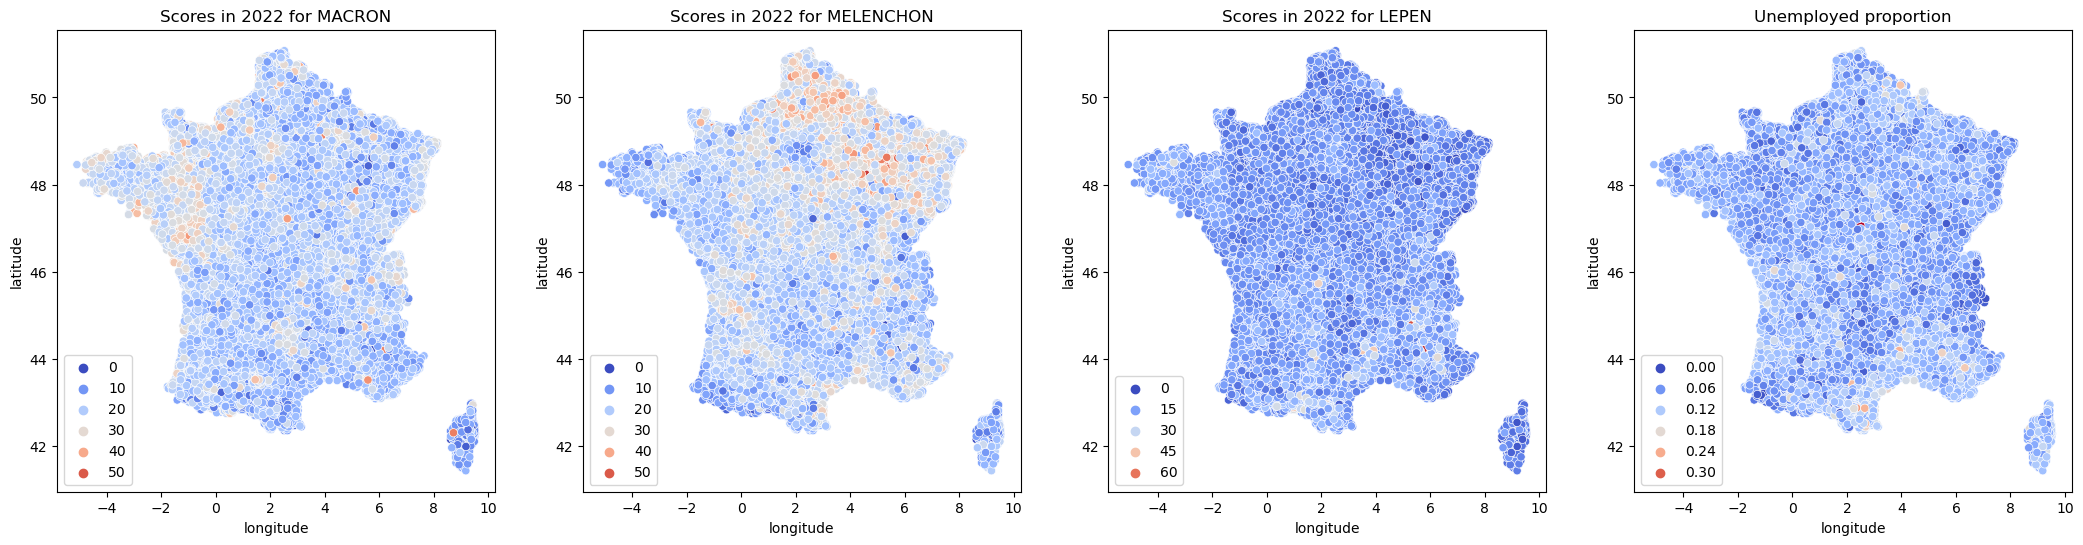

In [433]:
df_unemployement = y_train.copy()
df_unemployement["latitude"] = X_train["latitude"]
df_unemployement["longitude"] = X_train["longitude"]
df_unemployement['Unemployed_proportion'] = X_train['P19_CHOMEUR1564']/X_train['P19_POP1564']

fig, axes = plt.subplots(1, 4, figsize=(26, 6))
main_candidates = ['MACRON', "MELENCHON","LEPEN"]
for i, candidate in enumerate(main_candidates):
    sns.scatterplot(
        data=df_unemployement, 
        x="longitude",
        y="latitude",
        hue=f'% Voix/Ins_{candidate}_2022',
        palette='coolwarm',
        ax=axes[i],
    )
    axes[i].set_title(f'Scores in 2022 for {candidate}')
    axes[i].legend(loc=3)

sns.scatterplot(data=df_unemployement, x="longitude",y="latitude",hue="Unemployed_proportion",palette='coolwarm')
axes[3].set_title('Unemployed proportion')
axes[3].legend(loc=3)

,% Abs/Ins_2022,% Nuls/Ins_2022,% Blancs/Ins_2022,% Autres/Ins_2022,% Voix/Ins_MACRON_2022,% Voix/Ins_MELENCHON_2022,% Voix/Ins_LEPEN_2022,Unemployed_proportion
% Abs/Ins_2022,1.000000,-0.004645,-0.098502,-0.393067,-0.310549,-0.043454,-0.165560,0.244894
% Nuls/Ins_2022,-0.004645,1.000000,-0.037371,-0.073927,-0.082597,-0.056103,-0.063440,0.009004
% Blancs/Ins_2022,-0.098502,-0.037371,1.000000,0.013347,0.011038,-0.057612,-0.016486,-0.082079
% Autres/Ins_2022,-0.393067,-0.073927,0.013347,1.000000,-0.089861,-0.412405,-0.007035,-0.129738
% Voix/Ins_MACRON_2022,-0.310549,-0.082597,0.011038,-0.089861,1.000000,-0.319103,-0.201669,-0.320988
% Voix/Ins_MELENCHON_2022,-0.043454,-0.056103,-0.057612,-0.412405,-0.319103,1.000000,-0.467300,0.067848
% Voix/Ins_LEPEN_2022,-0.165560,-0.063440,-0.016486,-0.007035,-0.201669,-0.467300,1.000000,0.151704
Unemployed_proportion,0.244894,0.009004,-0.082079,-0.129738,-0.320988,0.067848,0.151704,1.000000


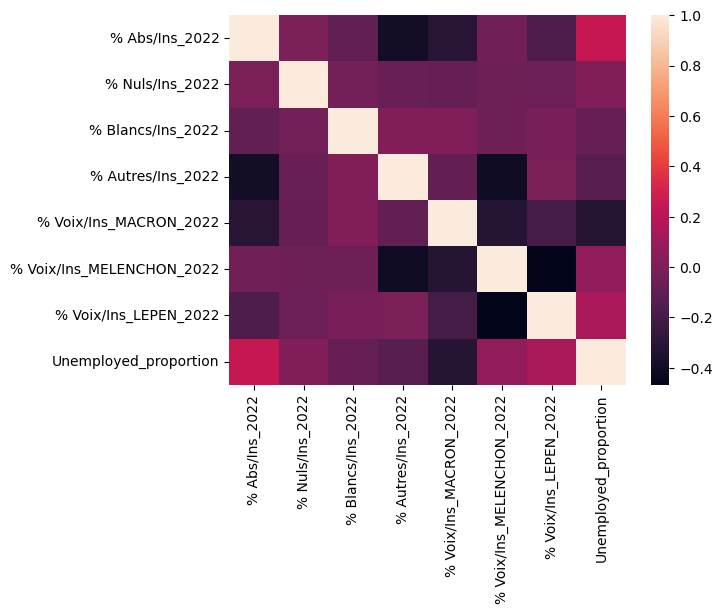

In [434]:
#### Seaborn heatmap correlation
correlation_unemployement = df_unemployement.drop(columns=["latitude", "longitude"]).corr()
sns.heatmap(correlation_unemployement)
correlation_unemployement

## Designing a submission

### Mandatory structure of a submission

A submission (should be stored in ./subsmissions/submission_foldername/) must contain a file named: estimator.py <br>

This file must contains a function: get_estimator() which return a model with:

- a fit(X, y) method
- a predict(X) method

We have already performed all data manipulations described above. In order to use the data after this preprocessing, use `get_test_data` and `get_train_data` functions. <br>

As an example, we design here the baseline method to solve the challenge.

In [4]:
import pandas as pd
import os
import numpy as np
from math import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error as mse
from math import *

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

def _removing_columns(X, columns):
    X = X.copy()
    X = X.drop(columns=columns)
    return X

class FeatureExtractor(BaseEstimator):
    def fit(self, X, y):
        return self

    def transform(self, X):
        X = _removing_columns(X, ['CODGEO', 'Departement'])
        return X.fillna(0)

def get_estimator():
    pip = Pipeline([
            ("FeatureExtractor",FeatureExtractor()),
            ("Preprocessor", StandardScaler()),
            ("Regressor", MultiOutputRegressor(Ridge(random_state=57)))
        ])
    return pip

pip = get_estimator()
pip.fit(X_train, y_train)

y_pred = pip.predict(X_test)
rmse = sqrt(mse(y_pred, y_test))

print("The root mean squared error on the test set with the baseline is: ", round(rmse, 2), "%")

The root mean squared error on the test set with the baseline is:  3.6 %


In [51]:
%load_ext autoreload
%autoreload 2
from submissions.starting_kit.estimator import *

pipe = get_estimator()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pipeline(steps=[('adding_location_data',
                 FunctionTransformer(func=<function add_location_data at 0x00000247979C3C10>)),
                ('adding_insee_data',
                 FunctionTransformer(func=<function add_external_data at 0x00000247979C30D0>)),
                ('remove_codgeo',
                 FunctionTransformer(func=<function removing_codgeo at 0x00000247979C3F70>)),
                ('preprocessor', StandardScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=Ridge(random_state=57)))])


In [52]:
pipe.fit(X_train, y_train)

In [53]:
y_pred = pipe.predict(X_test)

rmse = sqrt(mse(y_pred, y_test))

print("The root mean squared error on the test set with the baseline with features is: ", round(rmse, 2), "%")

The root mean squared error on the test set with the baseline with features is:  3.39 %


Our pipeline got slightly better results than the minimal values : it seems that 2022 strongly followed the same logics. Yet, we were able to increase our performances, and with better models the score should do nothing but lower.

## Quick submission test

You can test any submission locally by running:

In [1]:
! ramp-test --submission starting_kit

If you want to quickly test the that there are no obvious code errors, use the --quick-test flag to only use a small subset of the data.

In [ ]:
! ramp-test --submission starting_kit --quick-test

Testing French Presidential Elections
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
	score   rmse    mae  mixed      time
	train  3.410  2.187  2.799  0.082154
	valid  3.772  2.425  3.099  0.018146
	test   3.222  2.077  2.649  0.000000
CV fold 1
	score   rmse    mae  mixed      time
	train  3.450  2.206  2.828  0.046876
	valid  3.513  2.294  2.904  0.015620
	test   3.242  2.079  2.660  0.021561
CV fold 2
	score   rmse    mae  mixed      time
	train  3.463  2.220  2.842  0.054994
	valid  3.420  2.195  2.807  0.015791
	test   3.222  2.081  2.652  0.006929
CV fold 3
	score   rmse    mae  mixed      time
	train  3.445  2.216  2.830  0.058254
	valid  3.631  2.282  2.956  0.020649
	test   3.201  2.069  2.635  0.006000
CV fold 4
	score   rmse    mae  mixed      time
	train  3.504  2.250  2.877  0.049548
	valid  3.108  1.994  2.551  0.020751
	test   3.222  2.083  2.652  0.006997
CV fold 5
	score   rmse    mae  mixed      time
	trai